# Google Code Jam 2020 qualification round post analysis

https://codingcompetitions.withgoogle.com/codejam/round/000000000019fd27

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', 500)
plt.style.use('ggplot')  # set style

In [2]:
df = pd.read_json(r'./crawler/all_data_with_lang_by_rank.json').T

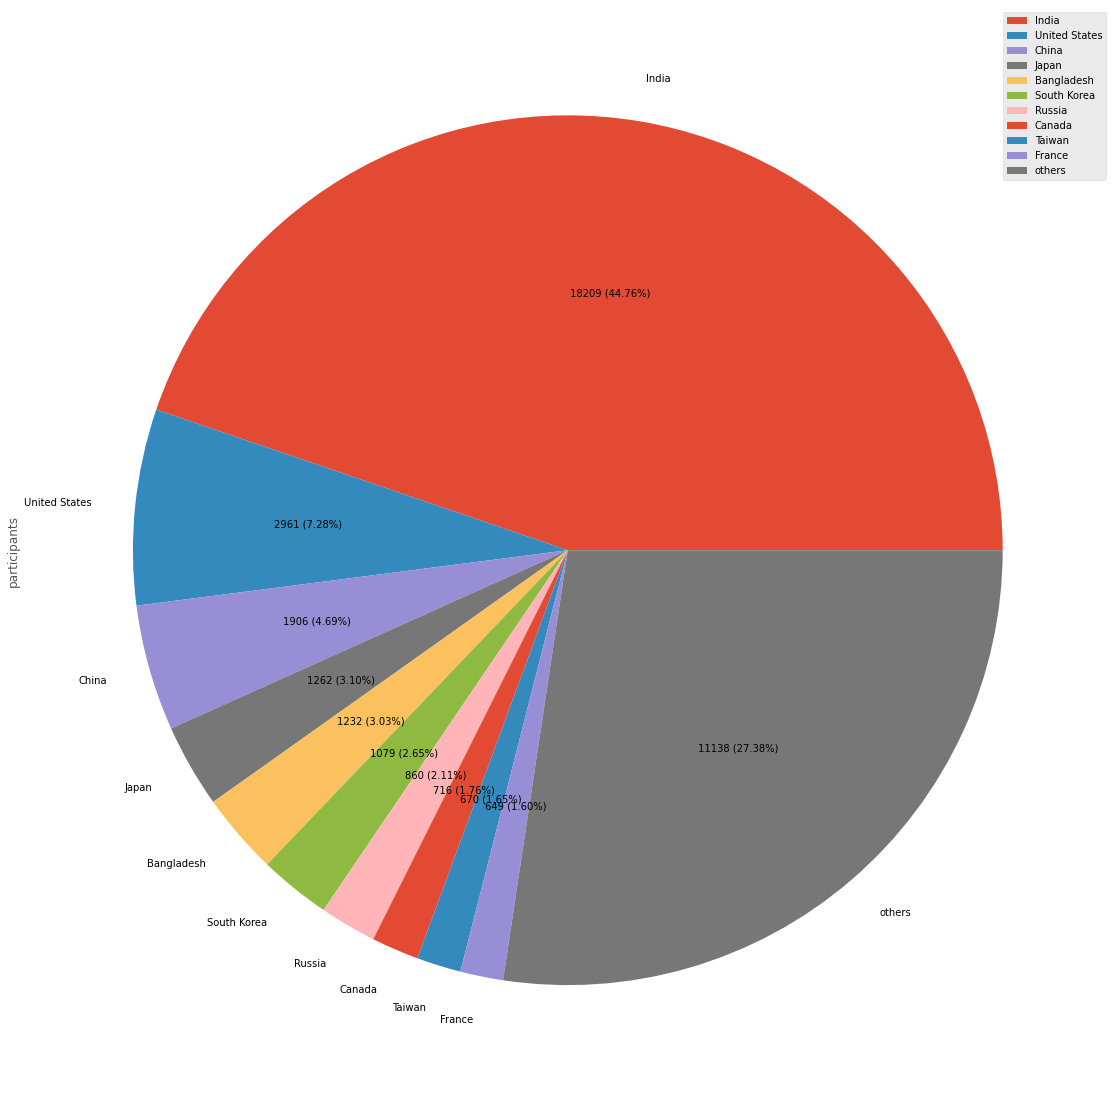

In [3]:
# group country by participants
df_countries = df.groupby(['country']).size().sort_values(ascending=False).reset_index(name='participants')

# get df: country with top 10 participants
df_countries_top = df_countries[:10].copy()

# get df: rest population in rest countries (one row)
df_countries_others = pd.DataFrame(
    data = {
        'country': ['others'],
        'participants' : [df_countries['participants'][10:].sum()]
    },
    index = ['10']                             
)

# combine above two df
countries_simple = pd.concat([df_countries_top, df_countries_others]).set_index('country')

# draw it
total = countries_simple.sum().participants
countries_simple.plot.pie(
    autopct=lambda p: '{:.0f} ({:.2f}%)'.format(p * total / 100, p),
    y='participants',
    figsize=(20, 20)
)

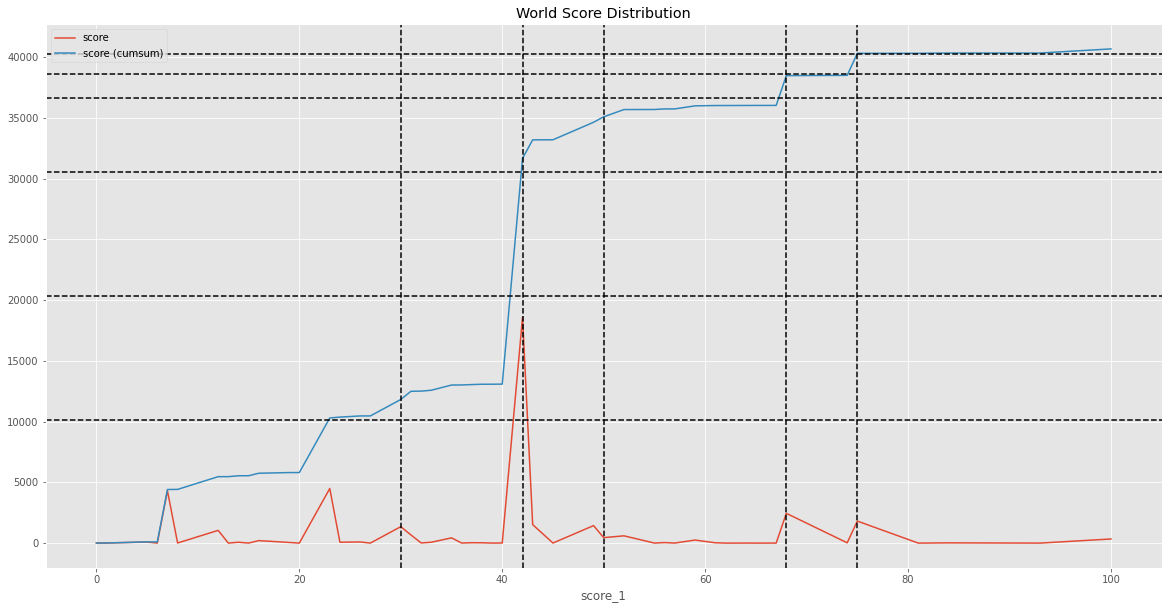

In [4]:
# get score count and score cumsum
df_score = df.groupby(['score_1']).size().reset_index(name='score')
df_score['score (cumsum)'] = df_score['score'].cumsum()

# draw line chart
line_chart = df_score.plot.line(x='score_1', figsize=(20,10), title='World Score Distribution')

# draw iconic score lines
vlines = [
    30,  # Round 1 cut-off
    42,  # solve first 3 basic questions,
    50,  # 42 + brute frucely solve 4th and 5th question
    68,  # solve first 4 questions
    75,  # 68 + brute frucely solve 5th question
]
for vl in vlines:
    line_chart.axvline(vl, color='k', linestyle='--')

# 25%, 50%, 75%, 90%, 95%, 99%
total = countries_simple.sum().participants
hlines = [total/4, total/2, 3*total/4, 9*total/10, 95*total/100, 99*total/100]
for hl in hlines:
    line_chart.axhline(hl, color='k', linestyle='--')

**Notes**

- There is a clear peak at "42". Participants can get 42 score by solving first 3 basic problems.
- There is another two small peak at "7", "23, "68" and "75". Participants can get 7 score by solving first problem, 23 score by solving first 2 problems, 68 score by solving first 4 problems, and 75 score by solving 4 problems plus 5th problem's 1st brute-forcable test case.

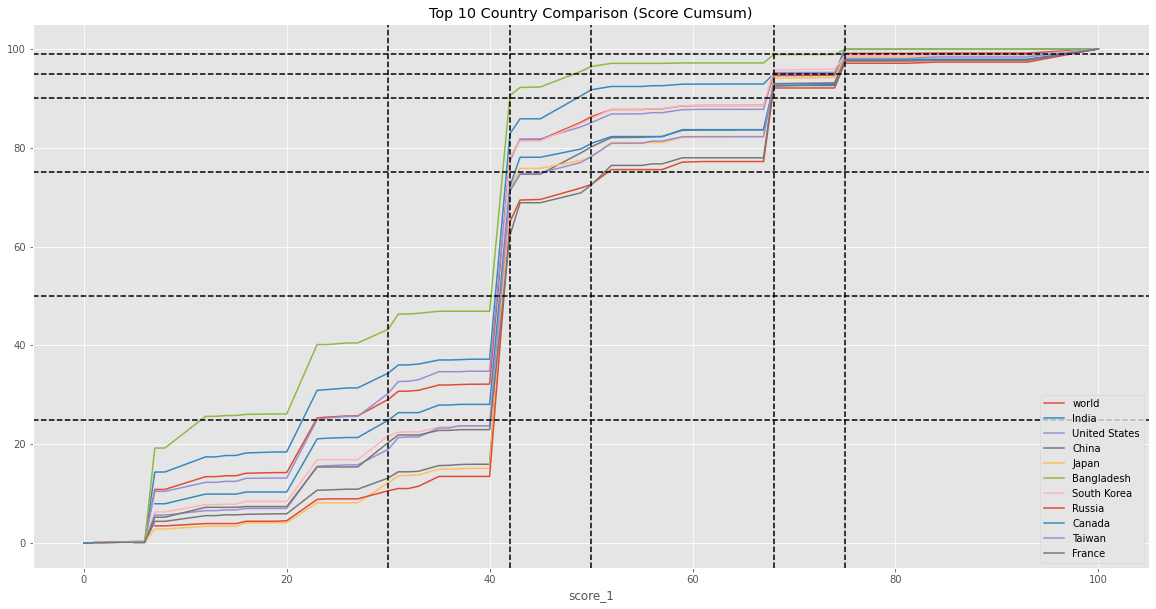

In [5]:
# calculate percentage of world score cumsum distribution
df_cnt = df.sort_values(by='rank').groupby(['score_1']).size().reset_index(name='count_world')
df_cnt['world'] = 100 * df_cnt['count_world'].cumsum() / df_cnt['count_world'].sum()
del df_cnt['count_world']

# calculate percentage of score cumsum distribution by country
for cc in df_countries_top['country']:
    df_country = df[df.country == cc].sort_values(by='rank')
    df_country_cnt = df_country.groupby(['score_1']).size().reset_index(name='count_' + cc)
    df_country_cnt[cc] = 100 * df_country_cnt['count_' + cc].cumsum() / df_country_cnt['count_' + cc].sum()
    del df_country_cnt['count_' + cc]
    df_cnt = pd.merge(df_cnt, df_country_cnt, how='left', on=['score_1']).fillna(method='ffill')

line_chart = df_cnt.plot.line(x='score_1', figsize=(20,10), title='Top 10 Country Comparison (Score Cumsum)')
vlines = [
    30,  # Round 1 cut-off
    42,  # solve first 3 basic questions
    50,  # 42 + brute frucely solve 4th and 5th question
    68,  # solve first 4 questions
    75,  # 68 + brute frucely solve 5th question
]
for vl in vlines:
    line_chart.axvline(vl, color='k', linestyle='--')
hlines = [25, 50, 75, 90, 95, 99]
for hl in hlines:
    line_chart.axhline(hl, color='k', linestyle='--')

**Notes**

- Steep line means worse performance, vice versa. For example, Bangladesh's performance (Green line) is relatively worse than any other countries, Japan's performance (Yellow line) is better than most countries in above graph. 

(0.0, 30.0)

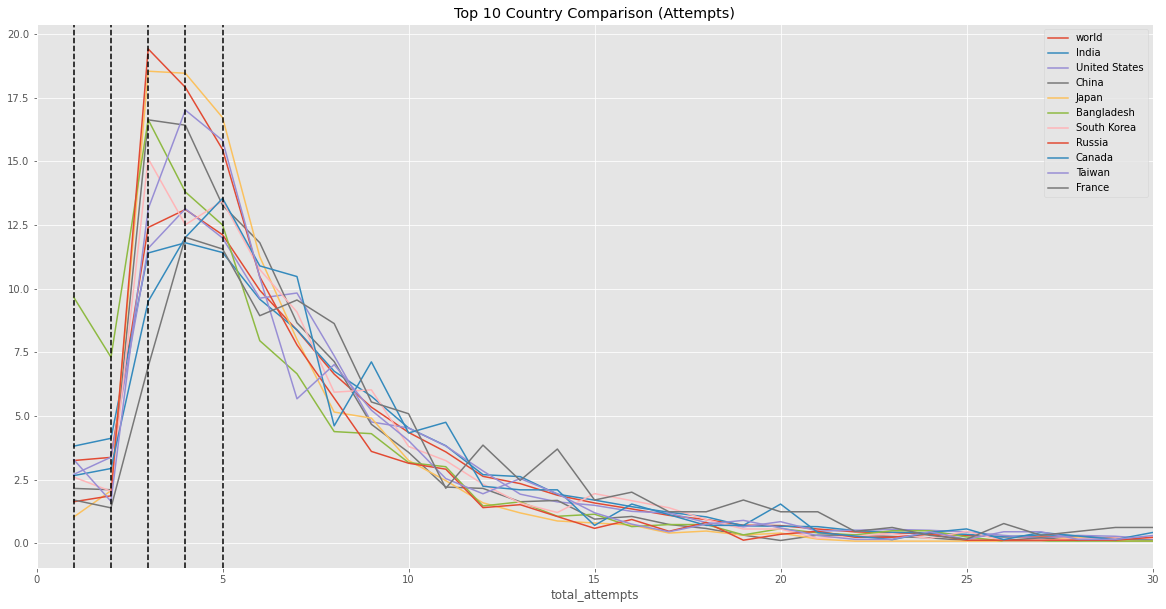

In [6]:
# calculate world total attempts distribution
df_acnt = df.groupby(['total_attempts']).size().reset_index(name='count_world')
df_acnt['world'] = 100 * df_acnt['count_world'] / df_acnt['count_world'].sum()
del df_acnt['count_world']

# calculate total attempts distribution by country
for cc in df_countries_top['country']:
    df_country = df[df.country == cc].sort_values(by='rank')
    df_country_acnt = df_country.groupby(['total_attempts']).size().reset_index(name='count_' + cc)
    df_country_acnt[cc] = 100 * df_country_acnt['count_' + cc] / df_country_acnt['count_' + cc].sum()
    del df_country_acnt['count_' + cc]
    df_acnt = pd.merge(df_acnt, df_country_acnt, how='left', on=['total_attempts']).fillna(method='ffill')

line_chart = df_acnt.plot.line(x='total_attempts', figsize=(20,10), title='Top 10 Country Comparison (Attempts)')
vlines = [1, 2, 3, 4, 5]
for vl in vlines:
    line_chart.axvline(vl, color='k', linestyle='--')
line_chart.set_xlim(0, 30)  # ignore attempts more than 30 times

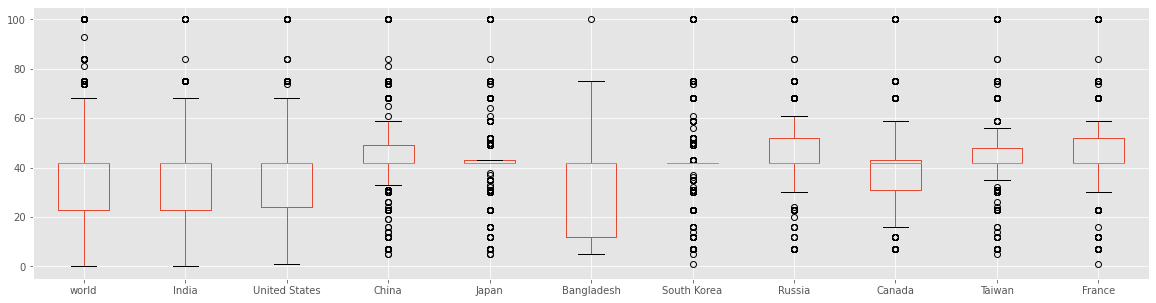

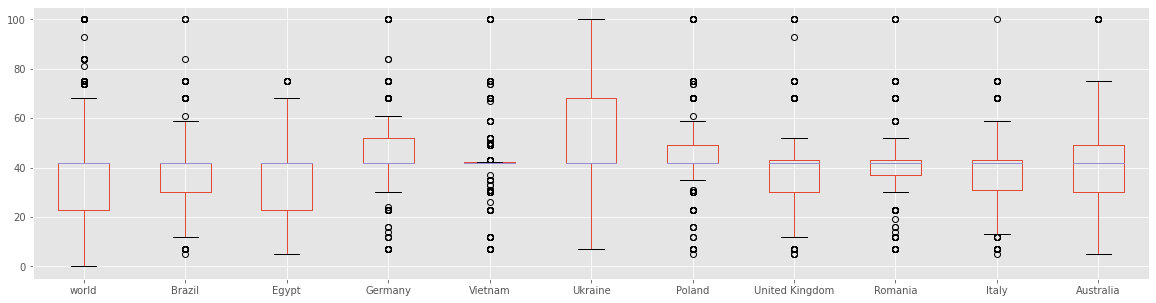

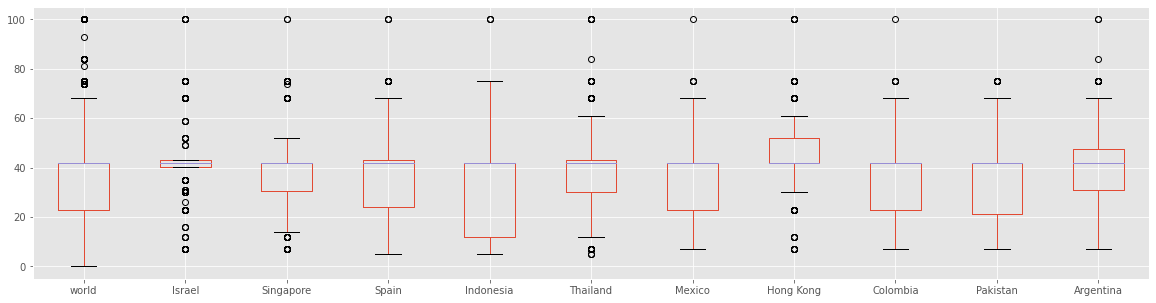

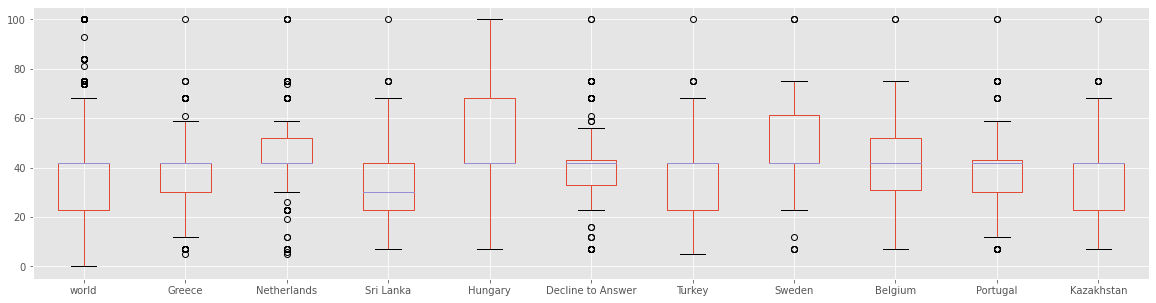

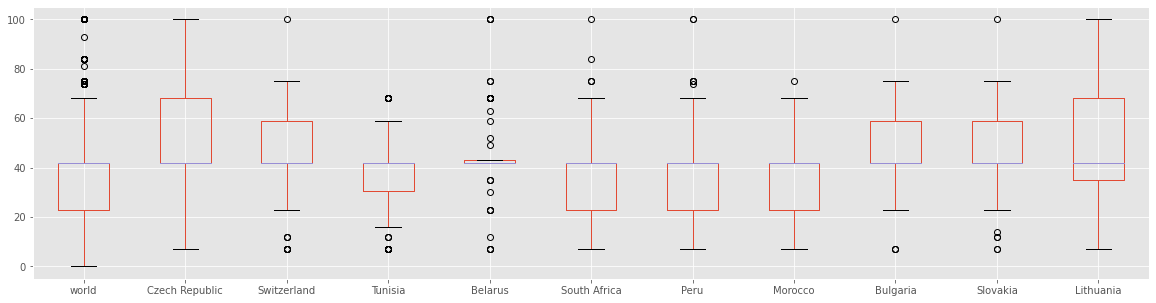

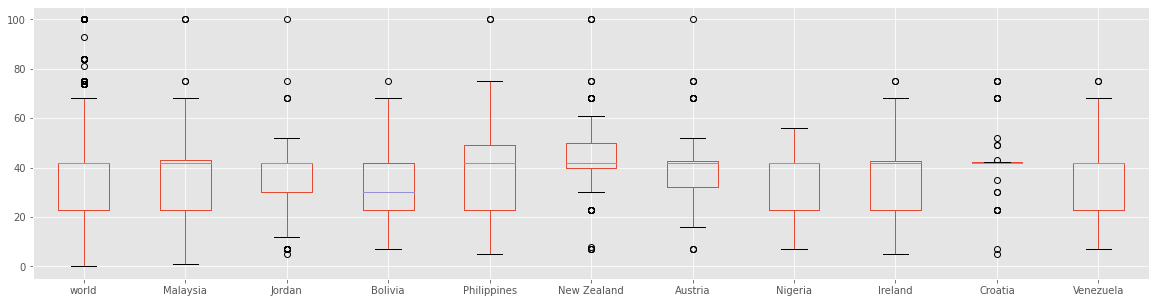

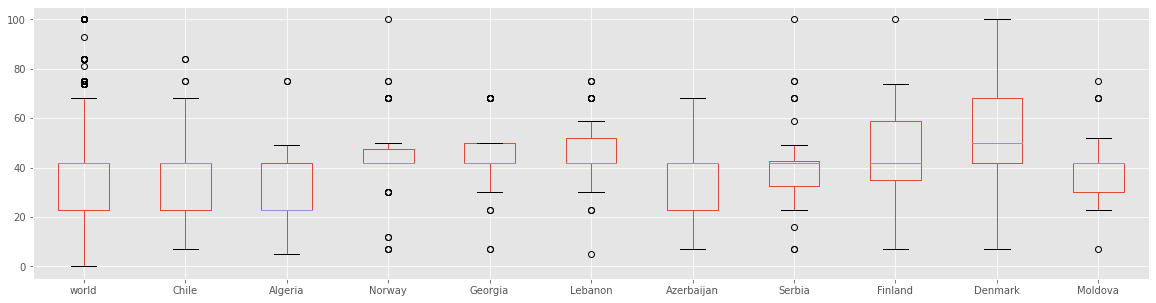

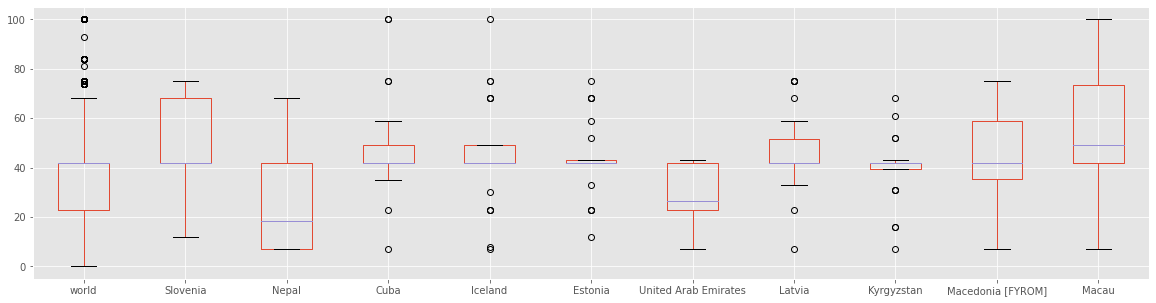

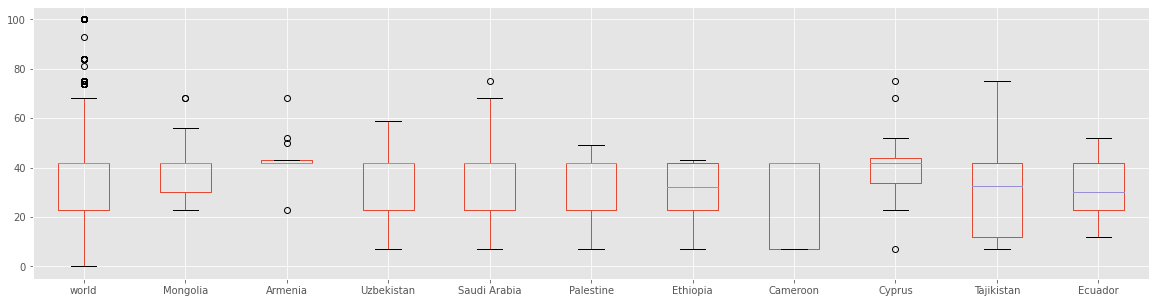

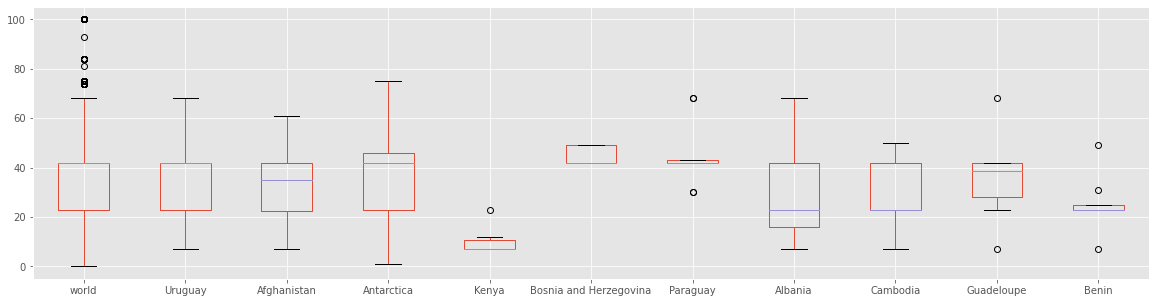

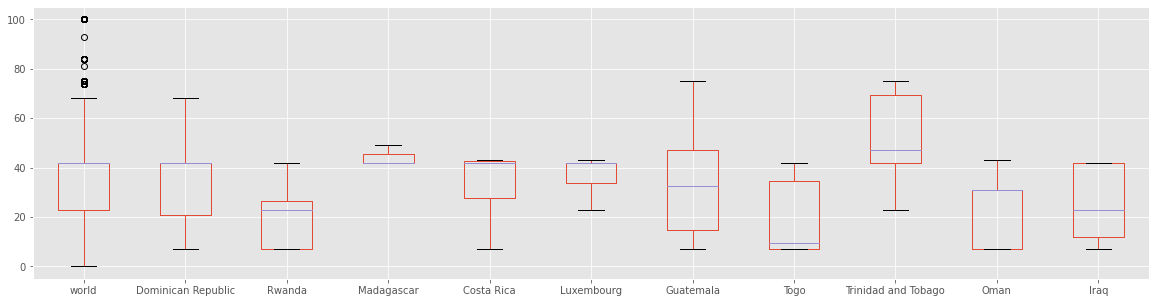

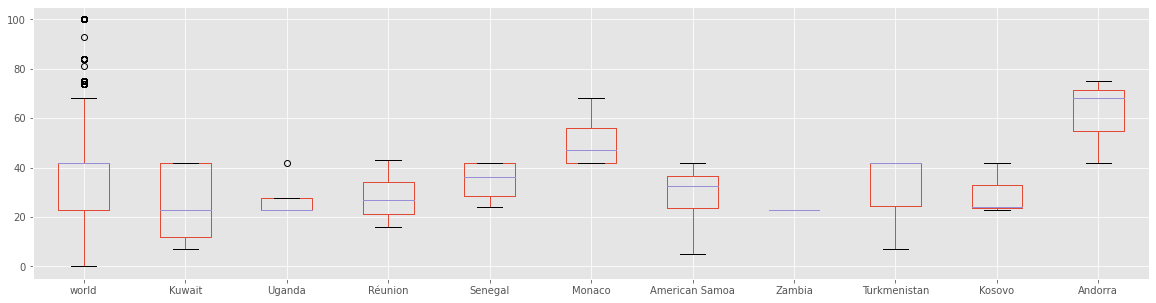

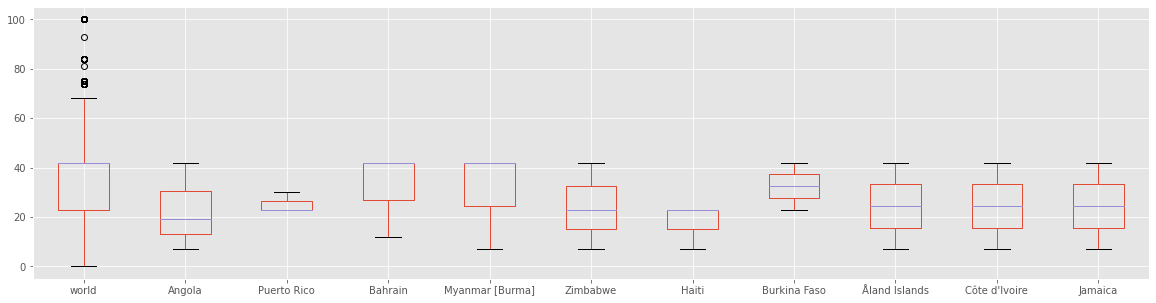

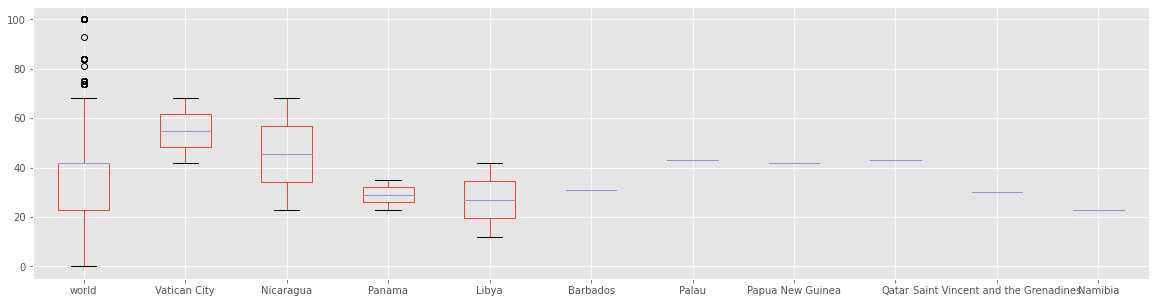

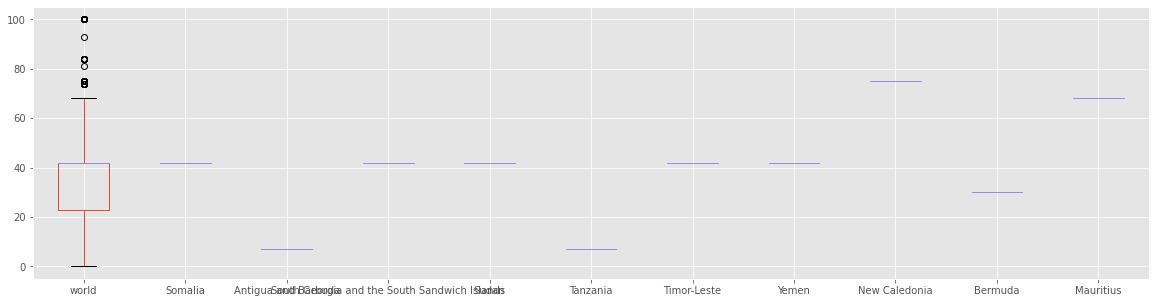

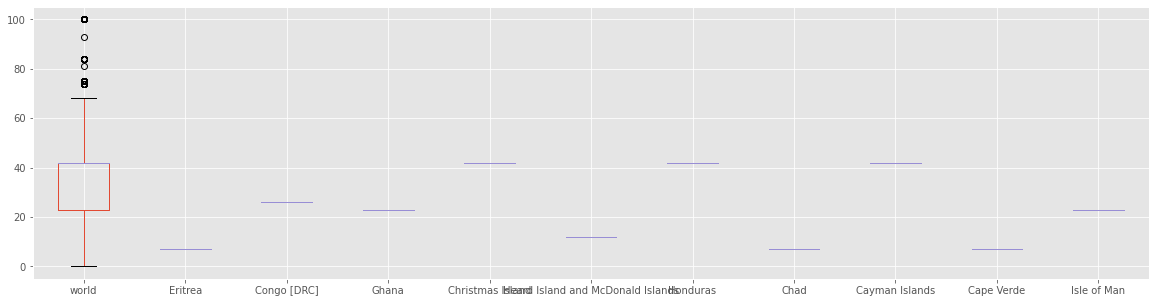

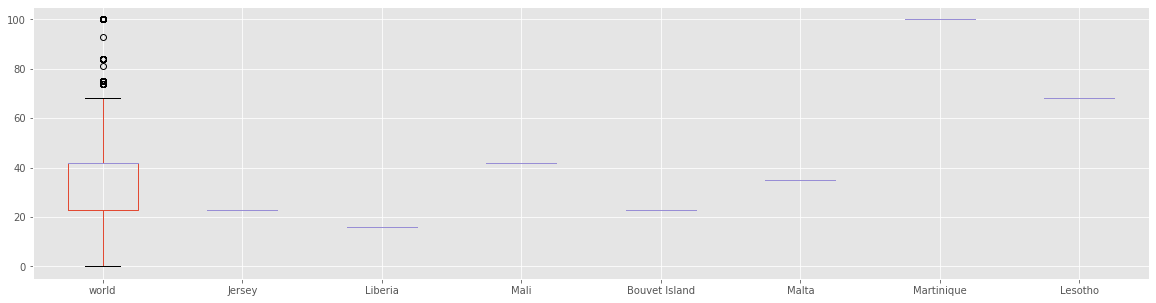

In [7]:
# calculate world score distribution
df_scores = pd.DataFrame(df['score_1'])
df_scores.columns = ['world']
df_base_scores = df_scores.copy()

# calculate score distribution by country
for idx, cc in enumerate(df_countries['country']):
    df_country = df[df.country == cc].sort_values(by='rank')
    df_scores_country = pd.DataFrame(df_country['score_1'])
    df_scores_country.columns = [cc]
    df_scores = df_scores.merge(df_scores_country, left_index=True, right_index=True, how='outer')

    # print 10 box in each figure
    if (idx + 1) % 10 == 0 or idx == len(df_countries) - 1:
        ax = df_scores.plot.box(figsize=(20, 5))
        df_scores = df_base_scores

**Notes**

- Each figure shows 10 countries plus world box.
- The country name is ordered by "participants numbers" rather than alphabets.
- Box length means "most people reaching certain range of score". Country with small length box like Japan, Vietnam, and South Korea means "most people's score are between x and y, x and y are very close.", vice versa.
- Few countries show strong average performance, such as Ukraine, Hungary, Denmark, and Macau.

<ipython-input-8-02e6a9032bb0>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_score = df.sort_values(by='rank')[df['score_1'] >= score]


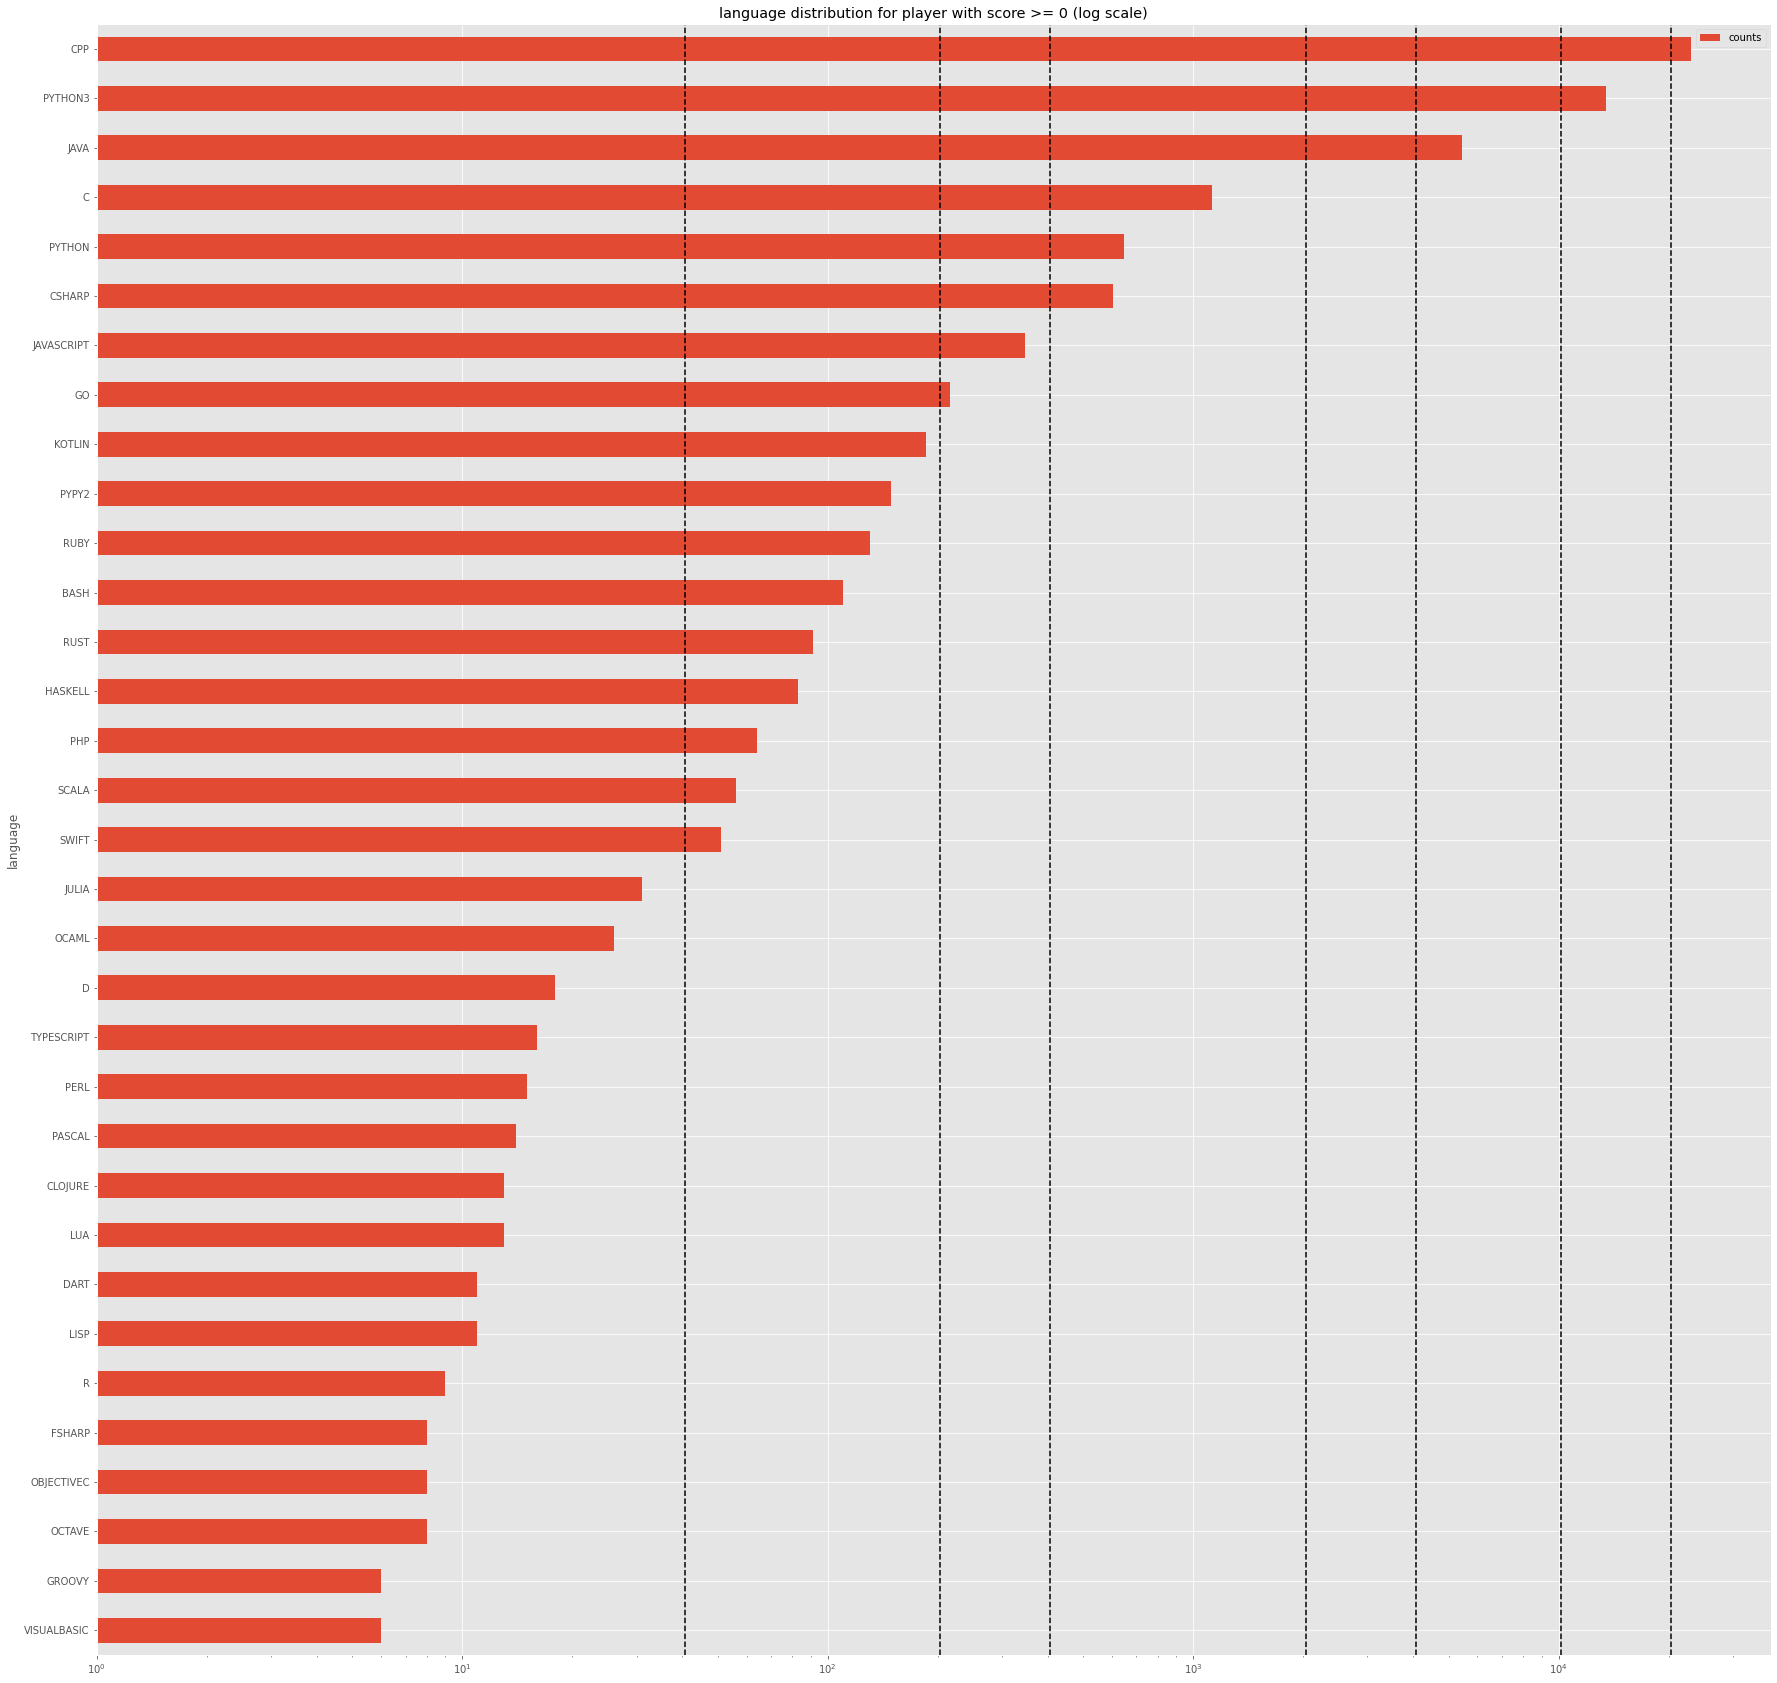

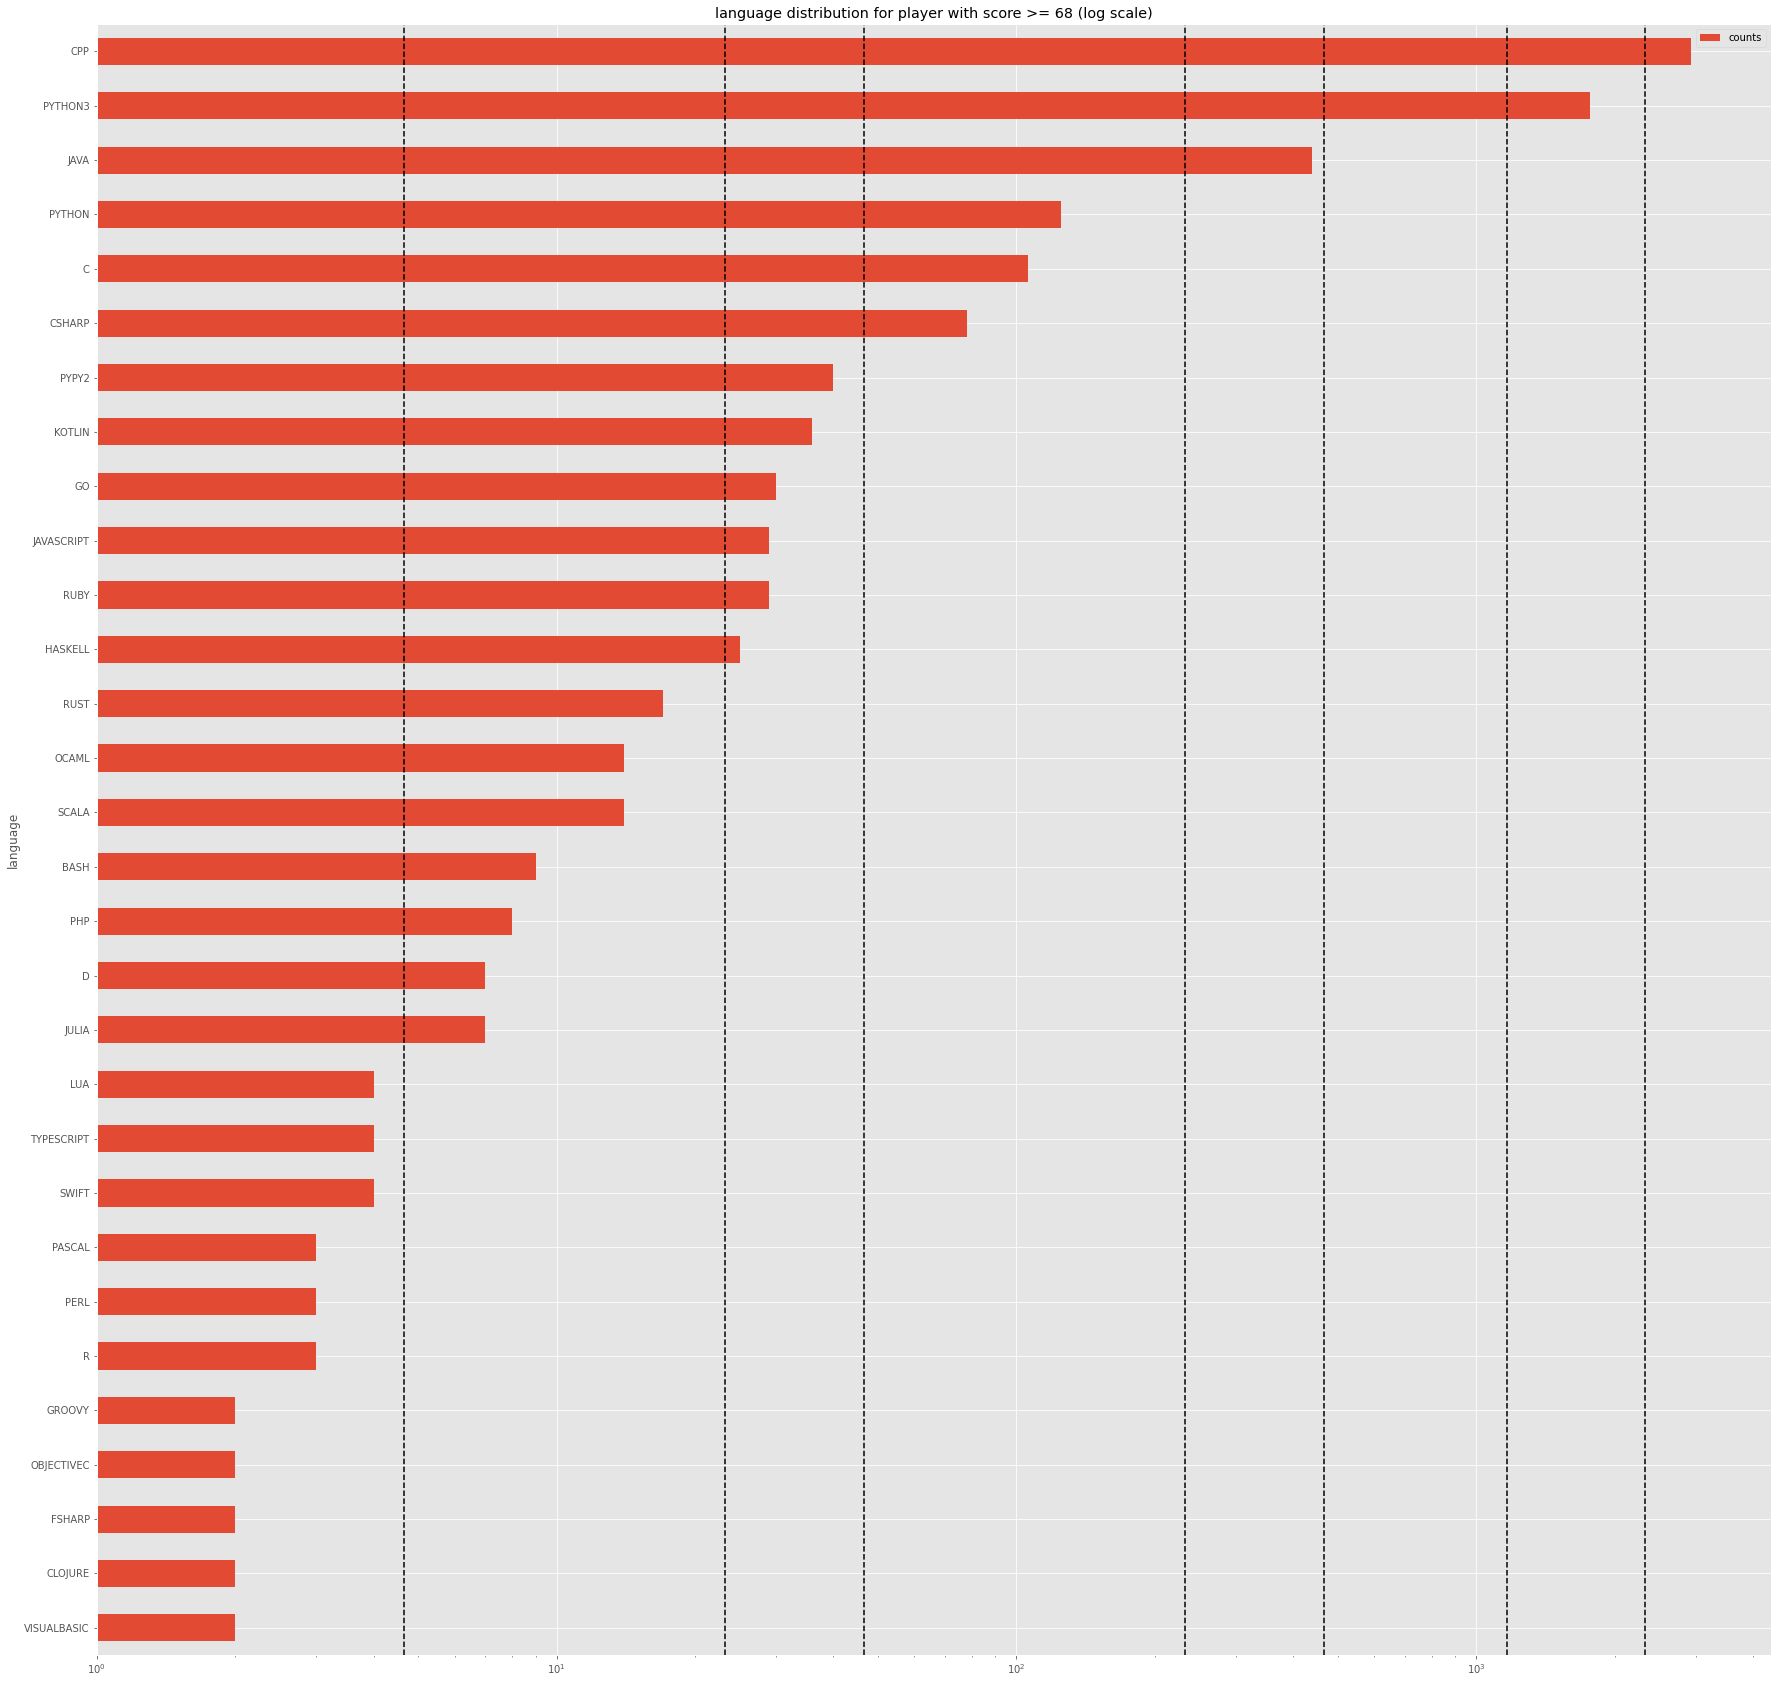

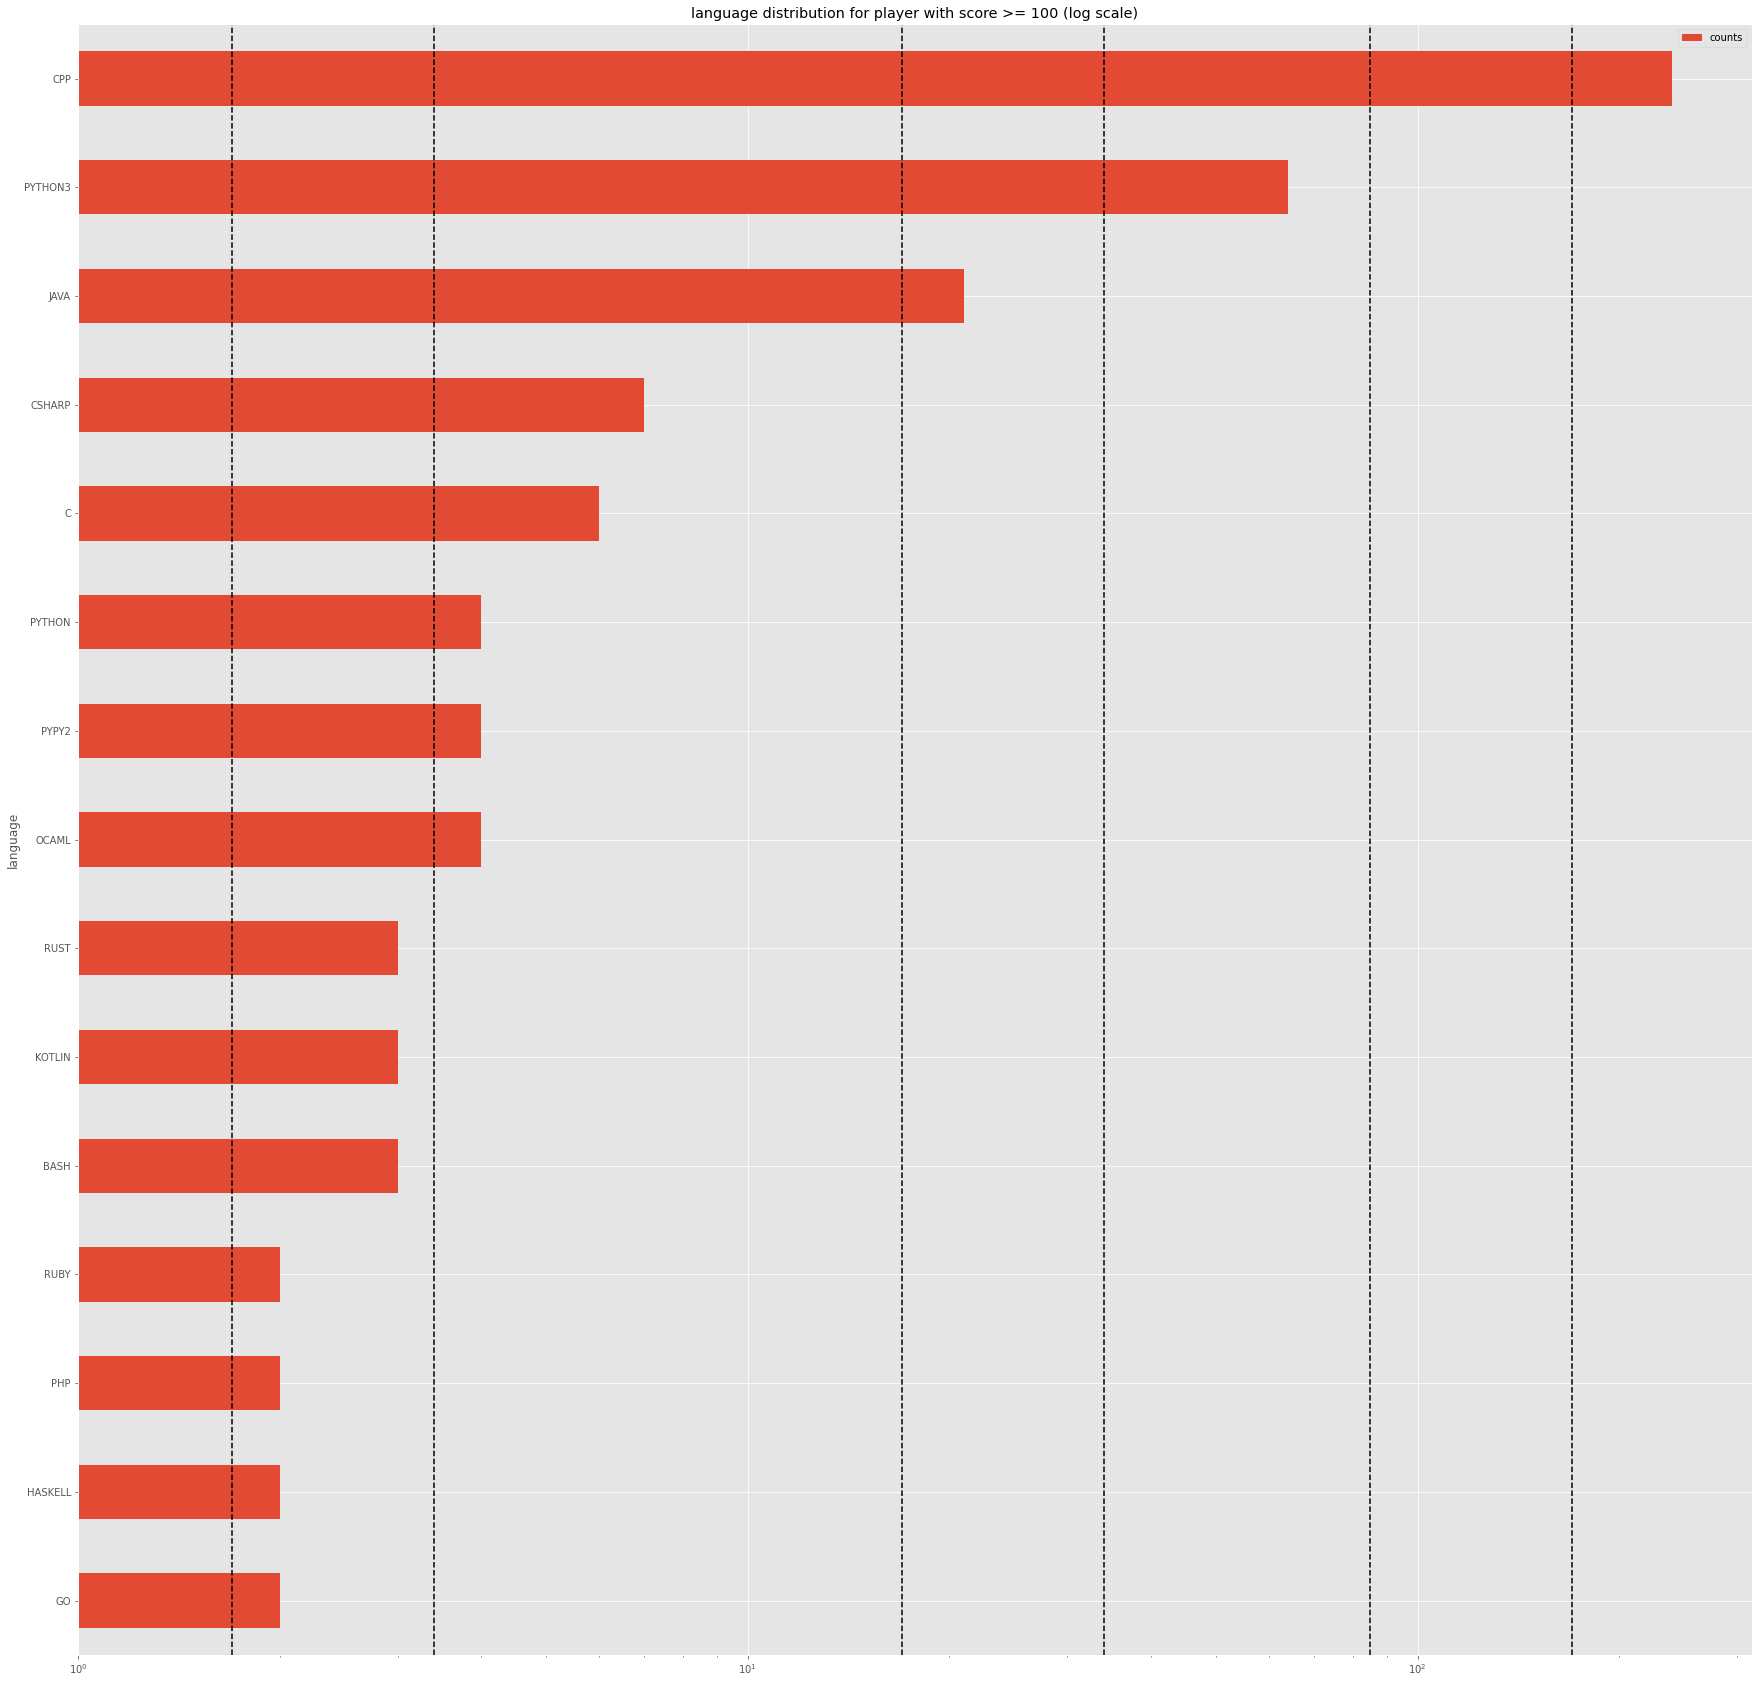

In [8]:
supported_lang = ['BASH', 'C', 'CLOJURE', 'CPP', 'CSHARP', 'D', 'DART', 'FSHARP', 'GO', 'GROOVY', 'HASKELL', 'JAVA', 'JAVASCRIPT', 'JULIA', 'KOTLIN', 'LISP', 'LUA', 'OBJECTIVEC', 'OCAML', 'OCTAVE', 'PASCAL', 'PERL', 'PHP', 'PYPY2', 'PYTHON', 'PYTHON3', 'R', 'RUBY', 'RUST', 'SCALA', 'SWIFT', 'TYPESCRIPT', 'VISUALBASIC']

iconic_scores = [
    0,   # all
    68,  # solve first 4 question (top player)
    100, # full score (elite player)
]

for score in iconic_scores:
    df_langs_per_user = pd.DataFrame({'counts': {}})
    df_langs_per_user.insert(0, 'language', None)
    
    df_score = df.sort_values(by='rank')[df['score_1'] >= score]
    total = len(df_score)

    for idx, lang in enumerate(supported_lang):
        df_lang = df_score.iloc[:, 2].apply(lambda x: x.count(lang))
        ls = df_lang.sum()
        if ls > 0:
            df_langs_per_user.loc[idx] = [lang, df_lang.sum()]   
        
    df_langs_per_user = df_langs_per_user.sort_values(by='counts',ascending=True)
    barh_chart = df_langs_per_user.plot(
        title=f'language distribution for player with score >= {score} (log scale)', 
        x='language', y='counts', kind='barh', figsize=[30,30], log=True)
    # barh_chart = df_langs_per_user.plot(x='language', y='counts', title=f'score', kind='barh', figsize=[30,30])
    
    # draw 0.5%, 1%, 5%, 10%, 25%, 50% vertical lines
    vlines = [total/200, total/100, total*5/100, total/10, total/4, total/2]
    # draw 0.1% vertical lines for top and all player graph
    if score < 100:
        vlines = [total/1000] + vlines
    for vl in vlines:
        barh_chart.axvline(vl, color='k', linestyle='--')


In [9]:
# Multi-languages analysis
supported_lang = ['BASH', 'C', 'CLOJURE', 'CPP', 'CSHARP', 'D', 'DART', 'FSHARP', 'GO', 'GROOVY', 'HASKELL', 'JAVA', 'JAVASCRIPT', 'JULIA', 'KOTLIN', 'LISP', 'LUA', 'OBJECTIVEC', 'OCAML', 'OCTAVE', 'PASCAL', 'PERL', 'PHP', 'PYPY2', 'PYTHON', 'PYTHON3', 'R', 'RUBY', 'RUST', 'SCALA', 'SWIFT', 'TYPESCRIPT', 'VISUALBASIC']

for i in range(0, 6):
    df_lang = df[df.languages.apply(lambda x: len(x) > i)].sort_values(by='rank')
    print(f'Users use more than {i} language in attempts: {len(df_lang)}')

Users use more than 0 language in attempts: 40574
Users use more than 1 language in attempts: 4761
Users use more than 2 language in attempts: 607
Users use more than 3 language in attempts: 82
Users use more than 4 language in attempts: 11
Users use more than 5 language in attempts: 2


In [10]:
# [Preprocess] Count language usages
supported_lang = ['BASH', 'C', 'CLOJURE', 'CPP', 'CSHARP', 'D', 'DART', 'FSHARP', 'GO', 'GROOVY', 'HASKELL', 'JAVA', 'JAVASCRIPT', 'JULIA', 'KOTLIN', 'LISP', 'LUA', 'OBJECTIVEC', 'OCAML', 'OCTAVE', 'PASCAL', 'PERL', 'PHP', 'PYPY2', 'PYTHON', 'PYTHON3', 'R', 'RUBY', 'RUST', 'SCALA', 'SWIFT', 'TYPESCRIPT', 'VISUALBASIC']

total_langs_by_country = {}
langs_by_country = {}
for cc in df_countries['country']:
    langs_by_country[cc] = {}
    df_country = df[df.country == cc]
    for lang in supported_lang:
        df_lang = df_country.iloc[:, 2].apply(lambda x: x.count(lang))
        langs_by_country[cc][lang] = df_lang.sum()
        total_langs_by_country[cc] = sum(langs_by_country[cc].values())

In [11]:
# [Debug] Top 5 languages per country
for cc in df_countries['country']:
    sd = {k: v for k, v in sorted(langs_by_country[cc].items(), key=lambda v: -v[1])}
    # print(f'{cc}: {list(sd.keys())[0:5]}')

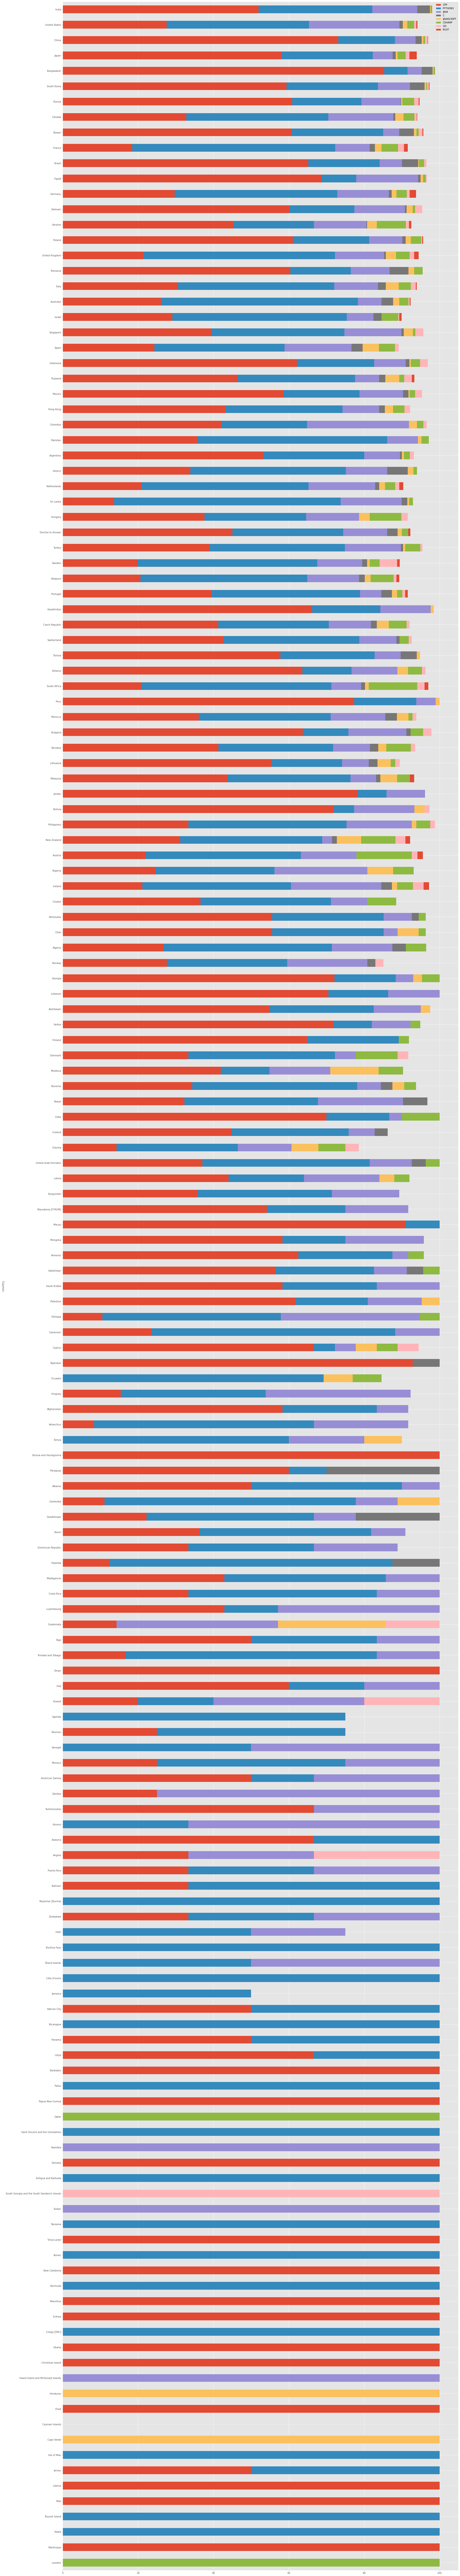

In [12]:
# Calculate popular lannguage percentage by country
observed_lang = ['CPP', 'PYTHON3', 'JAVA', 'C', 'JAVASCRIPT', 'CSHARP', 'GO', 'RUST']
nsd = {}
for cc in df_countries['country']:
    nsd[cc] = [0] * len(observed_lang)
    for k, v in langs_by_country[cc].items():
        if k in observed_lang:
            for i in range(len(observed_lang)):
                if k == observed_lang[i]:
                    nsd[cc][i] = 100 * v / total_langs_by_country[cc]
                    break

# Draw the language usage by country
df_nsd = pd.DataFrame(columns=['country'] + observed_lang)
for idx1, cc in enumerate(df_countries['country']):
    tdf = pd.DataFrame([[cc] + nsd[cc]], columns=['country'] + observed_lang)
    df_nsd = pd.concat([tdf, df_nsd], ignore_index=True)

df_nsd.plot.barh(x='country', stacked=True, figsize=[30,200])

**Notes**

- Language counts are based on attempts, a single player may have attempt with different languages. Therefore, the total language counts are larger than total players.
- We can only provide 99% confident data since the API is broken
  - There're 241 APIs require manual checks (only return undecodable data)
  - There're 108 APIs returns 0 submission (UI shows same result)
  - There're uncountable amount of undecodable attempts in API return